In [385]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

world_cities = pd.read_csv("worldcities.csv", header=None, skiprows=1)
world_cities = world_cities.to_numpy()

target_country = 'Russia'
world_cities[:,3] = np.where(world_cities[:,2] == target_country, 1, 0)

print(world_cities)

[[35.685 139.7514 'Japan' 0]
 [40.6943 -73.9249 'United States' 0]
 [19.4424 -99.131 'Mexico' 0]
 ...
 [69.651 162.3336 'Russia' 1]
 [74.0165 111.51 'Russia' 1]
 [61.1333 -100.8833 'Canada' 0]]


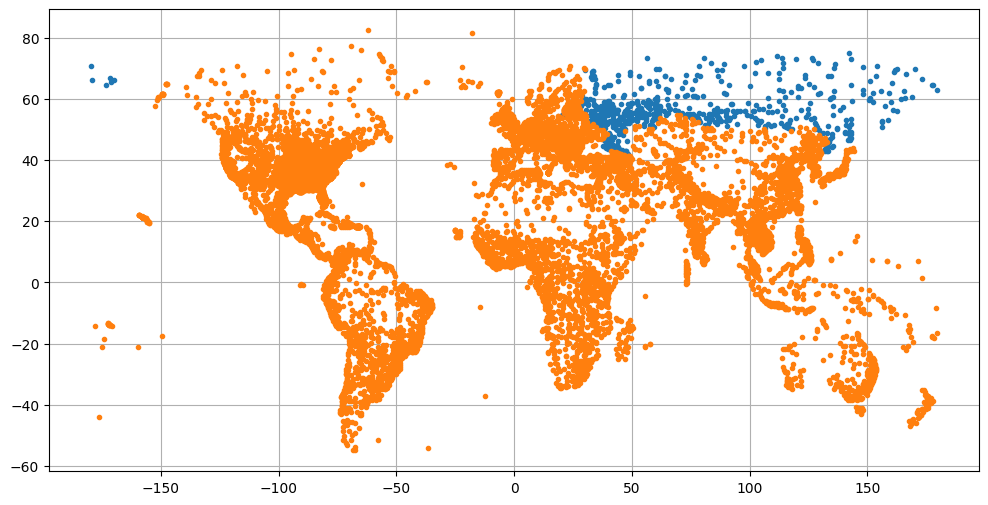

In [386]:
plt.figure(figsize=(12, 6))

correct_dots = world_cities[world_cities[:,2] == target_country]
incorrect_dots = world_cities[world_cities[:,2] != target_country]

plt.plot(correct_dots[:,1], correct_dots[:,0], ".", label='Верные')
plt.plot(incorrect_dots[:,1], incorrect_dots[:,0], ".", label='Неверные')

plt.grid()
plt.show()

In [387]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
!pip install torchsummary
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os

data = world_cities[:,0:2]
labels = world_cities[:,3]

data = data.astype(np.float32)
labels = labels.astype(np.float32)

inputs = torch.tensor(data, dtype=torch.float32)
outputs = torch.tensor(labels, dtype=torch.float32)

dataset = TensorDataset(inputs, outputs)

train_size = int(len(dataset) * 0.6)
val_size = int(len(dataset) * 0.2)
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [388]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_shape=2, num_classes=1, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            # nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
            # nn.Sigmoid()
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [389]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.is_available())

False


In [390]:
torchsummary.summary(NeuralNetwork().to(device), (2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]             768
              ReLU-2                  [-1, 256]               0
            Linear-3                  [-1, 128]          32,896
              ReLU-4                  [-1, 128]               0
            Linear-5                    [-1, 1]             129
Total params: 33,793
Trainable params: 33,793
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.13
Estimated Total Size (MB): 0.13
----------------------------------------------------------------


In [391]:
model = NeuralNetwork().to(device)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)# YOUR CODE HERE
loss_func = nn.BCEWithLogitsLoss()# YOUR CODE HERE

# Your experiments, training and validation loops here
def trainloop(dataloader, model, loss_f, opt):
    size = len(dataloader.dataset)
    model.train()
    train_loss = []
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        predict = model(X)
        predict = predict.squeeze(1)
        loss = loss_f(predict, y)
        opt.zero_grad()
        loss.backward()
        opt.step()

        train_loss.append(loss.item())

    print(f'loss:{np.mean(train_loss):>5f}')
    return np.mean(train_loss)

    

def testloop(dataloader, model, loss_f):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0

    TP,TN,FP,FN = 0,0,0,0

    with torch.no_grad():
        for X,y in dataloader:
            X,y = X.to(device),y.to(device)
            pred = model(X)
            pred = pred.squeeze(1)
            test_loss += loss_f(pred, y).item()

            pred = (pred > 0.5).int()
            y = y.int()

            TP += ((pred == 1) & (y == 1)).sum().item()
            TN += ((pred == 0) & (y == 0)).sum().item()
            FP += ((pred == 1) & (y == 0)).sum().item()
            FN += ((pred == 0) & (y == 1)).sum().item()
    test_loss /= num_batches
    print(f'loss:{test_loss:>5f}')
    return test_loss, TP, TN, FP, FN


def experiment(model, loss_func, opt):
    test_loss = []
    train_loss = []
    TP = []
    TN = []
    FP = []
    FN = []
    epochs = 0
    i = 0
    correct = 0

    target = 0.885
    while (i < 50):
        epochs += 1
        print(f"Epoch\t{epochs}\t")
        print(f"train ",end="")
        
        tmp1 = trainloop(train_loader, model, loss_func, opt)
        train_loss.append(tmp1)
        
        print(f"test ",end="")
        tmp1, TP_v, TN_v, FP_v, FN_v = testloop(test_loader, model, loss_func)
        test_loss.append(tmp1)
        TP.append(TP_v)
        TN.append(TN_v)
        FP.append(FP_v)
        FN.append(FN_v)

        i += 1
        
        
    print("Done!")   
    return train_loss, test_loss, TP, TN, FP, FN

train_loss, test_loss, TP, TN, FP, FN = experiment(model, loss_func, opt)

Epoch	1	
train loss:0.174537
test loss:0.103503
Epoch	2	
train loss:0.126432
test loss:0.085179
Epoch	3	
train loss:0.104871
test loss:0.090082
Epoch	4	
train loss:0.098419
test loss:0.075710
Epoch	5	
train loss:0.090181
test loss:0.080490
Epoch	6	
train loss:0.089061
test loss:0.084672
Epoch	7	
train loss:0.081435
test loss:0.066842
Epoch	8	
train loss:0.073250
test loss:0.078503
Epoch	9	
train loss:0.074628
test loss:0.055802
Epoch	10	
train loss:0.064815
test loss:0.066843
Epoch	11	
train loss:0.064256
test loss:0.049286
Epoch	12	
train loss:0.063669
test loss:0.065004
Epoch	13	
train loss:0.061786
test loss:0.064959
Epoch	14	
train loss:0.054149
test loss:0.053544
Epoch	15	
train loss:0.056740
test loss:0.043855
Epoch	16	
train loss:0.058099
test loss:0.048998
Epoch	17	
train loss:0.053955
test loss:0.045917
Epoch	18	
train loss:0.051620
test loss:0.038603
Epoch	19	
train loss:0.046657
test loss:0.036380
Epoch	20	
train loss:0.045746
test loss:0.039638
Epoch	21	
train loss:0.039790

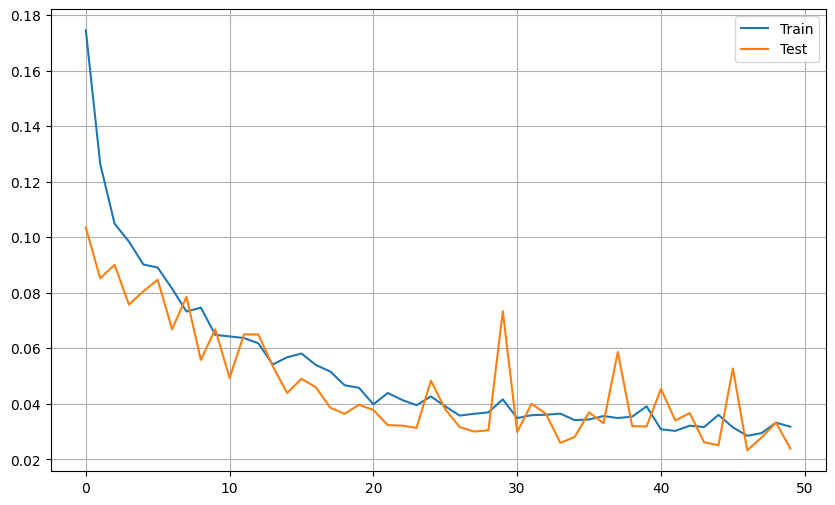

In [392]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

x = np.arange(50)

plt.plot(x, train_loss, label='Train')
plt.plot(x, test_loss, label='Test')

plt.legend()

plt.grid()
plt.show()

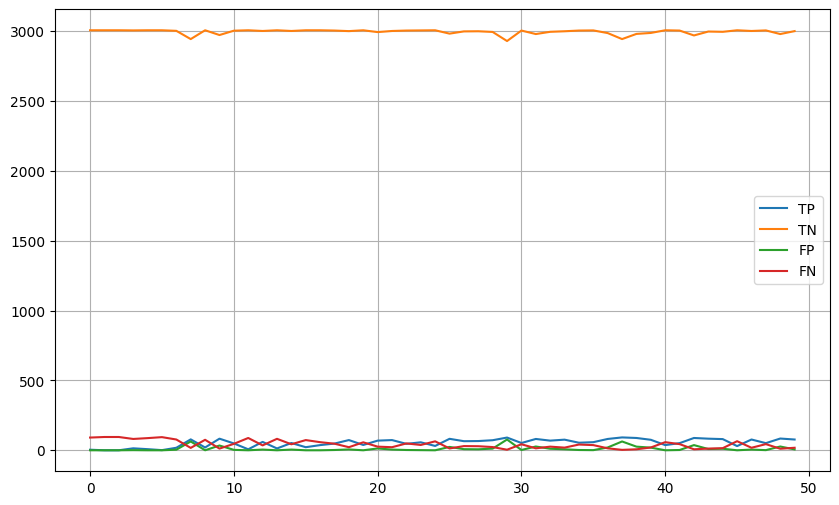

In [393]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

x = np.arange(50)

plt.plot(x, TP, label='TP')
plt.plot(x, TN, label='TN')
plt.plot(x, FP, label='FP')
plt.plot(x, FN, label='FN')

plt.legend()

plt.grid()
plt.show()

In [394]:
TN,TP,FN,FP = 0,0,0,0
TN_d = np.empty((0,2),dtype=float)
TP_d = np.empty((0,2),dtype=float)
FN_d = np.empty((0,2),dtype=float)
FP_d = np.empty((0,2),dtype=float)

for i in world_cities:
    inp = i[0:2].astype(np.float32)
    inp_tensor = torch.tensor(inp, dtype=torch.float32)
    res = model.forward(inp_tensor)
    res = int(res.item() > 0)
    # print(res,i[3])
    if res == 0:
        if res == i[3]:
            TN += 1
            TN_d = np.vstack([TN_d,[i[0],i[1]]])
        else:
            FN += 1
            FN_d = np.vstack([FN_d,[i[0],i[1]]])
    else:
        if res == i[3]:
            TP += 1
            TP_d = np.vstack([TP_d,[i[0],i[1]]])
        else:
            FP += 1
            FP_d = np.vstack([FP_d,[i[0],i[1]]])
    
print(TN,TP,FN,FP)
print(TN+TP+FN+FP)

14865 510 59 59
15493


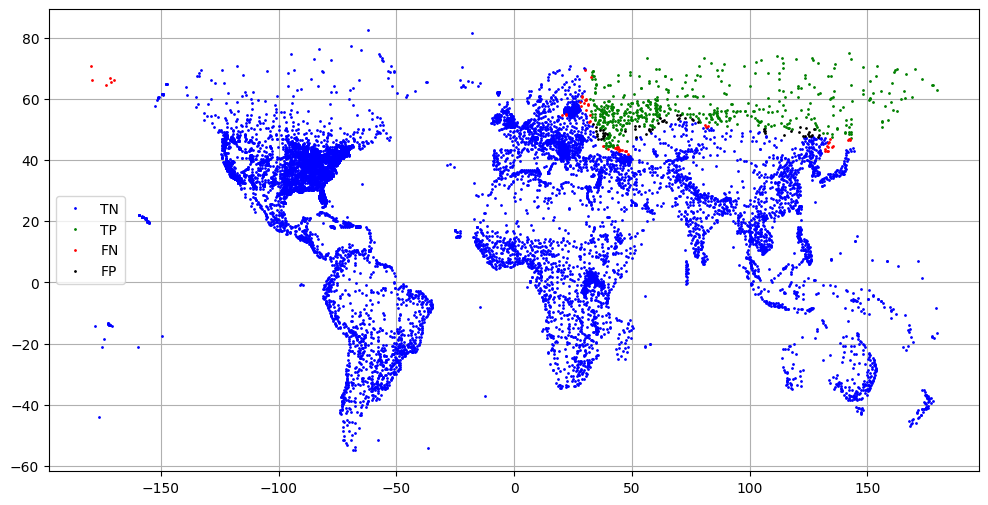

In [399]:
plt.figure(figsize=(12, 6))

plt.plot(TN_d[:,1], TN_d[:,0], "b.", label='TN', ms=2)
plt.plot(TP_d[:,1], TP_d[:,0], "g.", label='TP', ms=2)
plt.plot(FN_d[:,1], FN_d[:,0], "r.", label='FN', ms=2)
plt.plot(FP_d[:,1], FP_d[:,0], "k.", label='FP', ms=2)

plt.legend()

plt.grid()
plt.show()